In [1]:
# Python packages
from collections import namedtuple
import io
import json

# Scipy stack programs installable from conda
import pandas, numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np
plt.style.use('classic')

# Pip installable packages
import CoolProp.CoolProp as CP

In [2]:
import cCOSMO

db = cCOSMO.VirginiaTechProfileDatabase(
    "profiles/VT2005/Sigma_Profile_Database_Index_v2.txt", 
    "profiles/VT2005/Sigma_Profiles_v2/")
identifiers = [ "0438", "0087" ]  
for iden in identifiers:
    db.add_profile(iden)
    prof = db.get_profile(iden)
    print(prof.name)

COSMO = cCOSMO.COSMO1(identifiers, db)
T = 623.15;
z = np.array([0.235, 1-0.235])

%timeit COSMO.get_lngamma(T, z)
print(COSMO.get_lngamma(T, z))

# Print out what fluids are available in the database as a pandas DataFrame
j = json.loads(db.to_JSON()) # This is a dict, from numstring to info
j = [v for k,v in j.items()] # Remove the keys
pandas.DataFrame(j).set_index('VTIndex')

ACETONE
CYCLOPENTANE
352 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[0.27453833 0.02625747]


,CAS,V_COSMO_A3,name,numstring
VTIndex,,,,
1,74-82-8,37.95554,METHANE,0001
2,74-84-0,58.80969,ETHANE,0002
3,74-98-6,80.70296,PROPANE,0003
4,75-28-5,103.40846,ISOBUTANE,0004
5,106-97-8,102.43321,N-BUTANE,0005
...,...,...,...,...
1733,1795-21-7,329.15058,N-DECYLCYCLOPENTANE,1733
1734,5634-30-0,372.28100,N-DODECYLCYCLOPENTANE,1734
1735,6006-34-4,394.77882,N-TRIDECYLCYCLOPENTANE,1735


In [3]:
import cCOSMO
import numpy as np
db = cCOSMO.VirginiaTechProfileDatabase(
    "profiles/VT2005/Sigma_Profile_Database_Index_v2.txt", 
    "profiles/VT2005/Sigma_Profiles_v2/")
identifiers = ["0006", "0438"]
for iden in identifiers:
    db.add_profile(iden)
    prof = db.get_profile(iden)
    print(prof.name)
COSMO = cCOSMO.COSMO1(identifiers, db)
T = 298.15;
z = np.array([0, 1])
COSMO.get_lngamma_comb(T,z,0)
# %timeit COSMO.get_psigma_mix(z)
# psigma_mix = COSMO.get_psigma_mix(z)
# %timeit COSMO.get_Gamma(T, psigma_mix)
# %timeit COSMO.get_lngamma_resid(0, T, z)
# %timeit COSMO.get_lngamma(T, z)
# print(COSMO.get_lngamma(T, z))

N-PENTANE
ACETONE


-0.0513284036562387

ETHANOL
WATER


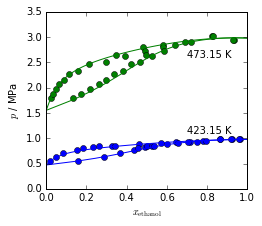

In [4]:
%matplotlib inline

class _fac(object):
    def __init__(self, j):
        assert(j['using_tau_r'])
        self.T_r = j['T_r']
        self.T_max = j['Tmax']
        self.T_min = j['Tmin']
        self.n = np.array(j['n'])
        self.t = np.array(j['t'])
        self.reducing_value = j['reducing_value']
    
    def psat(self, T):
        theta = 1-T/self.T_r
        RHS = np.dot(self.n,theta**self.t)
        return self.reducing_value*np.exp(self.T_r/T*np.sum(RHS))
    
    def dpsat_dT(self, T):
        im = 0+1j; h = 1e-10
        return (self.psat(T+im*h)/h).imag # Complex step derivative
        
def psat_factory(fluid):
    # Get the JSON structure from CoolProp
    pS = json.loads(CP.get_fluid_param_string(fluid,'JSON'))[0]['ANCILLARIES']['pS']
    return _fac(pS)

COSMOIsoline = namedtuple('COSMOIsoline', ['T','p','x0L','x0V'])
def get_isotherm(fluids, T):
    COSMO = cCOSMO.COSMO1(fluids, db)
    
    assert(len(fluids)==2)
    psats = [psat_factory(name) for name in fluids]
    TT,PP,X0L,X0V = [],[],[],[]
    for x0L in np.linspace(1e-6,1-1e-6):
        xL = [x0L, 1-x0L]
        gamma = np.exp(COSMO.get_lngamma(T, xL))
        p = gamma[0]*xL[0]*psats[0].psat(T) + gamma[1]*xL[1]*psats[1].psat(T)
        x0V = gamma[0]*xL[0]*psats[0].psat(T)/p
        TT.append(T); PP.append(p); X0L.append(x0L); X0V.append(x0V)
    return COSMOIsoline(TT, np.array(PP), np.array(X0L), X0V)

def get_isobar(fluids, p_Pa, Tguess):
    psats = [psat_factory(name) for name in fluids]
    assert(len(fluids)==2)
    TT,PP,X0L,X0V = [],[],[],[]
    for x0L in np.linspace(1e-6,1-1e-6):
        xL = [x0L, 1-x0L]
        def resid(T):
            gamma = np.exp(COSMO.get_lngamma(T, xL))
            pcalc = gamma[0]*xL[0]*psats[0].psat(T) + gamma[1]*xL[1]*psats[1].psat(T)
            return np.abs(pcalc-p_Pa)/p_Pa
        T = scipy.optimize.fsolve(resid, Tguess)
        gamma = np.exp(COSMO.get_lngamma(T, xL))
        p = p_Pa
        x0V = gamma[0]*xL[0]*psats[0].psat(T)/p
        TT.append(T); PP.append(p); X0L.append(x0L); X0V.append(x0V)
    return COSMOIsoline(np.array(TT),np.array(PP),np.array(X0L),X0V)

fluids = ['ETHANOL','WATER']
for iden in fluids:
    n = db.normalize_identifier(iden)
    db.add_profile(n)
    prof = db.get_profile(n)
    print(prof.name)

# Selected data from Barr-David, F.; Dodge, B. F., 
# Vapor-Liquid Equilibrium at High Pressures. The Systems Ethanol-Water and 2-Propanol-Water 
# J. Chem. Eng. Data, 1959, 4, 107-121
dataBarrDavid = io.StringIO("""T / K	p / MPa	x1 / molar	y1 / molar
423.15	0.55847534	0.018	0.159
423.15	0.627422913	0.048	0.288
423.15	0.703265244	0.084	0.367
423.15	0.779107574	0.155	0.438
423.15	0.806686603	0.184	0.458
423.15	0.827370875	0.232	0.490
423.15	0.841160389	0.264	0.503
423.15	0.841160389	0.326	0.528
423.15	0.848055147	0.34	0.535
423.15	0.896318448	0.463	0.600
423.15	0.91700272	0.572	0.658
423.15	0.930792234	0.648	0.704
423.15	0.930792234	0.717	0.749
423.15	0.958371263	0.781	0.797
423.15	0.985950292	0.862	0.862
423.15	0.985950292	0.923	0.919
423.15	0.985950292	0.966	0.961
473.15	1.792636895	0.023	0.134
473.15	1.868479226	0.032	0.175
473.15	1.9856901	0.048	0.219
473.15	2.068427187	0.066	0.262
473.15	2.158059032	0.088	0.299
473.15	2.268375148	0.112	0.337
473.15	2.337322721	0.157	0.381
473.15	2.475217867	0.214	0.424
473.15	2.509691654	0.295	0.466
473.15	2.654481557	0.345	0.495
473.15	2.626902527	0.391	0.528
473.15	2.806166217	0.479	0.579
473.15	2.730323887	0.491	0.586
473.15	2.840640003	0.58	0.641
473.15	2.909587576	0.689	0.719
473.15	3.013008936	0.824	0.828
473.15	2.95095612	0.934	0.929""")
colors = ['']
fig,ax = plt.subplots(1,1,figsize=(3.5, 3))
for T, group in pandas.read_csv(dataBarrDavid,sep='\t',comment='#').groupby('T / K'):
    line, = plt.plot(group['x1 / molar'], group['p / MPa'], 'o')
    plt.plot(group['y1 / molar'], group['p / MPa'], 'o', color=line.get_color())
    
    isoT = get_isotherm(fluids, T)
    plt.plot(isoT.x0L, isoT.p/1e6, label='bubble', color=line.get_color())
    plt.plot(isoT.x0V, isoT.p/1e6, label='dew', color=line.get_color())
    
plt.xlabel(r'$x_{\rm ethanol}$')
plt.ylabel(r'$p$ / MPa');
plt.text(0.7, 2.6, '473.15 K')
plt.text(0.7, 1.1, '423.15 K')
plt.tight_layout(pad=0.2)
plt.savefig('PX_ethanol_water.pdf')

In [5]:
%timeit get_isotherm(fluids, 423.15)
%timeit get_isobar(fluids, 101325.0, 373)

69.9 ms ± 585 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
281 ms ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


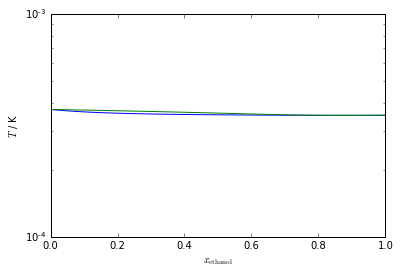

In [6]:
plt.figure()
for p in [101325.0]:
    isoP = get_isobar(fluids, p, 373)
    plt.plot(isoP.x0L, isoP.T/1e6, label='bubble')
    plt.plot(isoP.x0V, isoP.T/1e6, label='dew')
    
plt.xlabel(r'$x_{\rm ethanol}$')
plt.yscale('log')
plt.ylabel(r'$T$ / K');